![alt text](https://www.fridaylightsmusic.com/wp-content/uploads/2015/02/SenDemo.png)

# **Sendemo AI**
## *Written by My Koryto - CTO*
## *Research by:*
#### Danny Koryto - CEO // Sound Engineering Analysis.
#### My Koryto - CTO // Machine Learning Engineering.


### Content
1. Setup.
2. Data Analysis - Facets.
3. Feature Engineering.
4. Data Visualizations.
5. Simple Model - Logistic Regression.
6. Deep Neural Network - Numeric.
7. Gradiant Boost - Numeric.
8. NLP Feature Engineering.
9. NLP Text Classification Model - N Grams, TF IDF.
10. NLP Embedded Model - Word2vec.
11. Ensembled Model 1 - NLP X DNN
12. Ensembled Model 2 - NLP X LightGBM
**Will not be implemented due to the outperformance of the regular NLP model over the embedded model**
13. Ensembled Model 3 - NLP Embedded Model X DNN.
14. Ensembled Model 4 - NLP Embedded Model X LightGBM.
**----------------------------------------------------------------------------------------------** 
15. Final Model Selection.

#1. Setup

In [ ]:
# Access Google Sheets as a data source.
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
print("Setup succeed!")

Setup succeed!


In [ ]:
# Use the latest version of TensorFlow.
%tensorflow_version 2.x

# Data Manipulations.
import numpy as np
import pandas as pd
import math

# Machine Learning useful packages.
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
import time
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
!pip install shap
import shap

# TensorFlow.
import tensorflow as tf
from tensorflow.keras import layers

# Gradiant Boost.
import lightgbm as lgb

# Natural Language Processing.
import spacy
!python -m spacy download en_core_web_sm
from spacy.util import minibatch
import random
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string
import re

# Plotting Packages.
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Facets.
from google.colab import widgets
from IPython.core.display import display, HTML
import base64
!pip install facets-overview==1.0.0
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

     |████████████████████████████████| 112kB 361kB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


     |████████████████████████████████| 276kB 313kB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394112 sha256=f5cb8161e69dfa922b8dd5a19b661c8c75263abd5ed7ab57f1cd3bd1a3bf8269
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


Imported modules.


### 1.1. Data Preparation.

In [ ]:
### Access Google Sheets data.
# Create an instance of the workbook.
wb = gc.open_by_url('CONFIDENTIAL')

# Define feature names by dtype.
numerical_features = ['id', 'soundqual', 'musicprog', 'production', 'vocals', 'lyrics', 'melody', 'harmony', 'uniq', 'mix_lvl']
boolean_features = ['signed', 'worthsign', 'labelsuit', 'electronic', 'rock', 'pop', 'alternative', 'rb', 'military', 'children', 'folkwldcnt',
                    'funksoul', 'nonmusic', 'reggae', 'blues', 'classical', 'hiphop', 'jazz', 'latin', 'stgscreen']

# Create instances of the specific sheets.
sheet1 = wb.worksheet('SDNN')
sheet2 = wb.worksheet('SDNLP')

# Import the data from the sheets.
original_df1 = sheet1.get_all_values()
original_df2 = sheet2.get_all_values()

# Create pandas DataFrames.
DO_NOT_MODIFY1 = pd.DataFrame(original_df1)
DO_NOT_MODIFY2 = pd.DataFrame(original_df2)

# Copy the data to new DataFrames and clean the data.
df1 = DO_NOT_MODIFY1.copy()
df1.columns = df1.iloc[0]
df1 = df1.iloc[1:-2] # Limit when new unlabeled demos arrive

df2 = DO_NOT_MODIFY2.copy()
df2.columns = df2.iloc[0]
df2 = df2.iloc[1:-2]

# Eliminate NaNs.
df1.replace({'NaN': np.nan})
df1.replace({'na': np.nan})

# Eliminate whitespaces and change datatype to floats for numerical features.
for col in numerical_features:
  df1[col] = df1[col].str.strip()
  df1[col] = pd.to_numeric(df1[col], errors='coerce')

# Eliminate whitespaces and change datatype to floats for boolean features.
for col in boolean_features:
  df1[col] = df1[col].str.strip()
  df1[col] = pd.to_numeric(df1[col], errors='coerce')

# Create an interaction variable out of worthsign and labelsuit.
df1['labelsuit_x_worthsign'] = df1['labelsuit'] * df1['worthsign']

# Uncomment to randomize the dataset order.
#df1 = df1.reindex(np.random.permutation(df1.index))

# Set NaNs to the mean value.
df1.fillna(value = df1.mean(), inplace=True)

print("Setup succeed! df1:", len(df1), "df2:", len(df2))

# Show a sample of the data.
df2.tail()
df1.tail()

Setup succeed! df1: 192 df2: 192


,id,signed,worthsign,labelsuit,soundqual,musicprog,production,vocals,lyrics,melody,harmony,uniq,mix_lvl,electronic,rock,pop,alternative,rb,military,children,folkwldcnt,funksoul,nonmusic,reggae,blues,classical,hiphop,jazz,latin,stgscreen,labelsuit_x_worthsign
188,187,0,0,0,70.0,70.0,70.0,60.8,56.4,70.0,70.0,70.0,70.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
189,188,1,1,1,80.0,90.0,90.0,60.8,56.4,80.0,80.0,80.0,90.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
190,189,0,0,0,80.0,80.0,80.0,60.8,56.4,70.0,70.0,70.0,80.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
191,190,0,0,0,70.0,70.0,70.0,60.8,56.4,70.0,70.0,70.0,70.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
192,191,0,0,0,70.0,70.0,70.0,60.8,56.4,70.0,70.0,70.0,70.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#2. Data Analysis

####2.1 Facets

In [ ]:
#Visualize the Data in Facets
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': df1, 'name': 'numericDataset'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

In [ ]:
df_dive = df1.sample(SAMPLE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=df_dive)
display(HTML(html))

#3. Feature Engineering

####3.1. Initial logistic model evaluation

In [ ]:
# Data Preperation
y = df1.signed
feature_cols = ['labelsuit_x_worthsign', 'musicprog', 'production']
X = df1[feature_cols]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

# Model Creation
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Dense(1, input_dim=len(feature_cols), activation='sigmoid', name='input_layer'))
#model.add(Dense(1, activation='sigmoid', name='output_layer'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create Logger
#tensorboard = TensorBoard(log_dir='logs/{}'.format(time.time()),
#                    histogram_freq = 1,
#                    embeddings_freq = 1,
#                    embeddings_data = X)
# Model Summary
model1.summary()

# Model Fit
model1.fit(train_X, train_y, batch_size=128, epochs=500, validation_split = 0.15 ,shuffle=True, verbose=2)#, callbacks=[tensorboard])

# Evaluate Model
print('\n# Evaluate on test data')
results1 = model1.evaluate(test_X, test_y, batch_size=128)
print('test loss, test acc:', results1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 - 0s - loss: 44.8076 - accuracy: 0.0738 - val_loss: 41.7888 - val_accuracy: 0.0909
Epoch 2/500
1/1 - 0s - loss: 44.6733 - accuracy: 0.0738 - val_loss: 41.6635 - val_accuracy: 0.0909
Epoch 3/500
1/1 - 0s - loss: 44.5390 - accuracy: 0.0738 - val_loss: 41.5381 - val_accuracy: 0.0909
Epoch 4/500
1/1 - 0s - loss: 44.4048 - accuracy: 0.0738 - val_loss: 41.4127 - val_accuracy: 0.0909
Epoch 5/500
1/1 - 0s - loss: 44.2705 - accuracy: 0.0738 - val_loss: 41.2874 - val_accuracy: 0.0909
Epoch 6/500
1/1 - 0s - loss: 44.1362 - accuracy: 0.0738 - val_loss: 41.1620 - val_accuracy: 0.0909
Epoch 7/500
1/1 - 0s - loss: 44.0019 - accuracy: 0.0738 - val_

####3.2. Normalization

In [ ]:
numerical_features = ['soundqual', 'musicprog', 'production', 'vocals', 'lyrics', 'melody', 'harmony', 'uniq', 'mix_lvl']
df1[numerical_features] = df1[numerical_features] / 10
df1[numerical_features] = (df1[numerical_features] - df1[numerical_features].mean()) / df1[numerical_features].std()
df1.tail()

,id,signed,worthsign,labelsuit,soundqual,musicprog,production,vocals,lyrics,melody,harmony,uniq,mix_lvl,electronic,rock,pop,alternative,rb,military,children,folkwldcnt,funksoul,nonmusic,reggae,blues,classical,hiphop,jazz,latin,stgscreen,labelsuit_x_worthsign
188,187,0,0,0,-0.1,-0.0,-0.2,0.0,-0.0,-0.1,-0.1,-0.0,-0.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
189,188,1,1,1,0.5,1.2,1.0,0.0,-0.0,0.6,0.6,0.6,0.9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
190,189,0,0,0,0.5,0.6,0.4,0.0,-0.0,-0.1,-0.1,-0.0,0.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
191,190,0,0,0,-0.1,-0.0,-0.2,0.0,-0.0,-0.1,-0.1,-0.0,-0.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
192,191,0,0,0,-0.1,-0.0,-0.2,0.0,-0.0,-0.1,-0.1,-0.0,-0.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


####3.3. Post-Normalization Logit models.

In [ ]:
# Data Preperation
y = df1.signed
feature_cols = ['labelsuit_x_worthsign', 'musicprog', 'mix_lvl']
X = df1[feature_cols]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

# Model Creation
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Dense(1, input_dim=len(feature_cols), activation='sigmoid', name='input_layer'))
#model.add(Dense(1, activation='sigmoid', name='output_layer'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

# Model Fit
model2.fit(train_X, train_y, batch_size=128, epochs=500, validation_split = 0.15, shuffle=True, verbose=2)

# Evaluate Model
print('\n# Evaluate on test data')
results2 = model2.evaluate(test_X, test_y, batch_size=128)
print('test loss, test acc:', results2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 - 0s - loss: 0.6952 - accuracy: 0.5246 - val_loss: 0.6388 - val_accuracy: 0.6364
Epoch 2/500
1/1 - 0s - loss: 0.6945 - accuracy: 0.5246 - val_loss: 0.6384 - val_accuracy: 0.6364
Epoch 3/500
1/1 - 0s - loss: 0.6939 - accuracy: 0.5246 - val_loss: 0.6379 - val_accuracy: 0.6364
Epoch 4/500
1/1 - 0s - loss: 0.6933 - accuracy: 0.5246 - val_loss: 0.6375 - val_accuracy: 0.6364
Epoch 5/500
1/1 - 0s - loss: 0.6927 - accuracy: 0.5246 - val_loss: 0.6370 - val_accuracy: 0.6364
Epoch 6/500
1/1 - 0s - loss: 0.6920 - accuracy: 0.5246 - val_loss: 0.6366 - val_accuracy: 0.6364
Epoch 7/500
1/1 - 0s - loss: 0.6914 - accuracy: 0.5246 - val_loss: 0.636

#4. Data Visualizations

####4.1 Scatter plots of key features - Demonstration of important correlations.

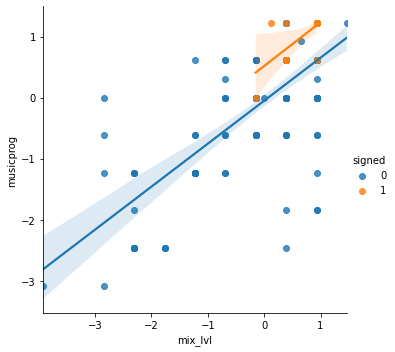

In [ ]:
vis1 = sns.lmplot(x='mix_lvl', y='musicprog', hue='signed', data=df1)

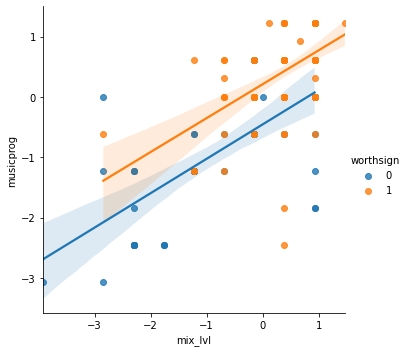

In [ ]:
vis1a = sns.lmplot(x='mix_lvl', y='musicprog', hue='worthsign', data=df1)

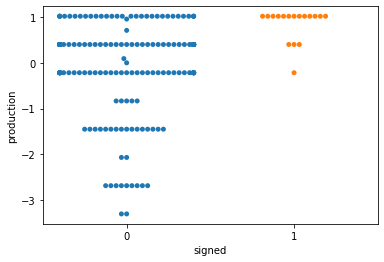

In [ ]:
vis2 = sns.swarmplot(x=df1['signed'],
                     y=df1['production'])

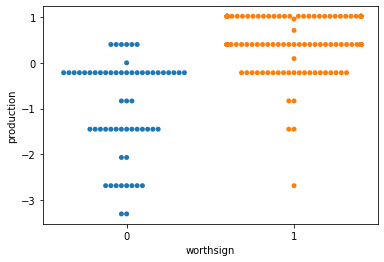

In [ ]:
vis2a = sns.swarmplot(x=df1['worthsign'],
                     y=df1['production'])

####4.2. Historgrams - Explore key features distribution

Text(0.5, 1.0, 'Distribution of key features')

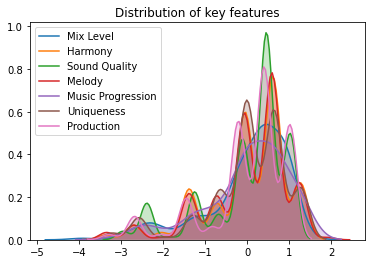

In [ ]:
# KDE plots for key numerical features
sns.kdeplot(data=df1['mix_lvl'], label="Mix Level", shade=True)
sns.kdeplot(data=df1['harmony'], label="Harmony", shade=True)
sns.kdeplot(data=df1['soundqual'], label="Sound Quality", shade=True)
sns.kdeplot(data=df1['melody'], label="Melody", shade=True)
sns.kdeplot(data=df1['musicprog'], label="Music Progression", shade=True)
sns.kdeplot(data=df1['uniq'], label="Uniqueness", shade=True)
sns.kdeplot(data=df1['production'], label="Production", shade=True)



# Add title
plt.title("Distribution of key features")

#5. Simple Model - Logistic Regression

####5.1. Logit model - 'Signed' as target

In [ ]:
# Data Preperation
y = df1.signed
feature_cols = ['labelsuit_x_worthsign', 'worthsign', 'labelsuit', 'musicprog', 'mix_lvl', 'soundqual', 'production','melody', 'harmony', 'uniq']
X = df1[feature_cols]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

# Model Creation
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Dense(1, input_dim=len(feature_cols), activation='sigmoid', name='input_layer'))
#model.add(Dense(1, activation='sigmoid', name='output_layer'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

model3.summary()

# Model Fit
model3.fit(train_X, train_y, batch_size=128, epochs=1000, validation_split = 0.15, shuffle=True, verbose=2)


# Evaluate Model
print('\n# Evaluate on test data')
results3 = model3.evaluate(test_X, test_y, batch_size=128)
print('test loss, test acc:, test AUC:', results3)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 - 0s - loss: 0.8486 - accuracy: 0.3852 - auc: 0.8515 - val_loss: 0.8534 - val_accuracy: 0.3636 - val_auc: 0.7500
Epoch 2/1000
1/1 - 0s - loss: 0.8469 - accuracy: 0.3852 - auc: 0.8510 - val_loss: 0.8522 - val_accuracy: 0.3636 - val_auc: 0.7375
Epoch 3/1000
1/1 - 0s - loss: 0.8451 - accuracy: 0.3852 - auc: 0.8476 - val_loss: 0.8510 - val_accuracy: 0.3636 - val_auc: 0.7500
Epoch 4/1000
1/1 - 0s - loss: 0.8434 - accuracy: 0.4016 - auc: 0.8491 - val_loss: 0.8498 - val_accuracy: 0.3636 - val_auc: 0.7500
Epoch 5/1000
1/1 - 0s - loss: 0.8417 - accuracy: 0.4016 - auc: 0.8476 - val_loss: 0.8486 - val_accuracy: 0.3636 - val_auc: 0.7500
Ep


####5.2. Logit model - 'worthsign' as target

In [ ]:
# Data Preperation
y = df1.worthsign
feature_cols = ['labelsuit', 'musicprog', 'mix_lvl', 'soundqual', 'melody', 'harmony', 'uniq', 'production']
X = df1[feature_cols]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

# Model Creation
model4 = tf.keras.models.Sequential()
model4.add(tf.keras.layers.Dense(1, input_dim=len(feature_cols), activation='sigmoid', name='input_layer'))
#model.add(Dense(1, activation='sigmoid', name='output_layer'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

model4.summary()

# Model Fit
model4.fit(X, y, batch_size=32, epochs=1000, validation_split = 0.15, shuffle=True, verbose=2)

# Evaluate Model
print('\n# Evaluate on test data')
results4 = model4.evaluate(test_X, test_y, batch_size=32)
print('test loss, test acc:, test AUC:', results4)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
6/6 - 0s - loss: 0.7988 - accuracy: 0.3252 - auc: 0.2862 - val_loss: 0.7046 - val_accuracy: 0.4138 - val_auc: 0.3636
Epoch 2/1000
6/6 - 0s - loss: 0.7825 - accuracy: 0.3620 - auc: 0.3054 - val_loss: 0.6971 - val_accuracy: 0.4483 - val_auc: 0.3766
Epoch 3/1000
6/6 - 0s - loss: 0.7667 - accuracy: 0.4049 - auc: 0.3251 - val_loss: 0.6896 - val_accuracy: 0.5862 - val_auc: 0.3929
Epoch 4/1000
6/6 - 0s - loss: 0.7513 - accuracy: 0.4417 - auc: 0.3548 - val_loss: 0.6826 - val_accuracy: 0.6207 - val_auc: 0.3961
Epoch 5/1000
6/6 - 0s - loss: 0.7367 - accuracy: 0.4785 - auc: 0.3804 - val_loss: 0.6759 - val_accuracy: 0.6207 - val_auc: 0.4026
Epoc

#6. Deep Neural Network

####6.1. Shallow NN with sigmoid activation function (output) & relu activation function (hidden), 'signed' as target.



In [ ]:
# Data Preperation
y = df1.signed
feature_cols = ['labelsuit_x_worthsign', 'worthsign', 'labelsuit', 'musicprog', 'mix_lvl', 'soundqual', 'melody', 'harmony', 'uniq', 'production']
X = df1[feature_cols]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

# Model Creation
model5 = tf.keras.models.Sequential()
model5.add(tf.keras.layers.Dense(20, input_dim=len(feature_cols), activation='relu', name='input_layer'))
model5.add(tf.keras.layers.Dense(15, activation='sigmoid', name='hid_layer_1'))
#model5.add(tf.keras.layers.Dense(6, activation='relu', name='hid_layer_2'))
model5.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer'))
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

# Create Logger
#tensorboard = TensorBoard(log_dir='logs/{}'.format(time.time()),
#                    histogram_freq = 1,
#                    embeddings_freq = 1,
#                    embeddings_data = X)
# Model Summary
model5.summary()

# Model Fit
model5.fit(train_X, train_y, batch_size=128, epochs=500, validation_split = 0.15, shuffle=True, verbose=2)#, callbacks=[tensorboard])

# Evaluate Model
print('\n# Evaluate on test data')
results5 = model5.evaluate(test_X, test_y, batch_size=128)
print('test loss, test acc:, test AUC:', results5)

# Save Model
# model5.save("sendemo_koryto_model.h5")
# print("Model saved to disk.")

# Model Explanation - BUGGED
#explainer = shap.DeepExplainer(model5, val_X)
#shap_values = explainer.shap_values(val_X)
#shap.summary_plot(shap_values, -val_X)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 20)                220       
_________________________________________________________________
hid_layer_1 (Dense)          (None, 15)                315       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 16        
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 - 1s - loss: 0.5413 - accuracy: 0.8689 - auc: 0.3850 - val_loss: 0.5664 - val_accuracy: 0.8182 - val_auc: 0.2500
Epoch 2/500
1/1 - 0s - loss: 0.5350 - accuracy: 0.8852 - auc: 0.3859 - val_loss: 0.5599 - val_accuracy: 0.8182 - val_auc: 0.2500
Epoch 3/500
1/1 - 0s - loss: 0.5288 - accuracy: 0.8852 - auc: 0.3741 - val_loss: 0.5534 - val_accuracy: 0.8182 - val_auc: 0.237

####6.2. Shalow NN with sigmoid activation function (output) & relu activation function (hidden), 'worthsign' as target.

In [ ]:
# Data Preperation
y = df1.worthsign
feature_cols = ['labelsuit', 'production','musicprog', 'mix_lvl', 'soundqual', 'melody', 'harmony', 'uniq']
X = df1[feature_cols]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

# Model Creation
model6 = tf.keras.models.Sequential()
model6.add(tf.keras.layers.Dense(20, input_dim=len(feature_cols), activation='relu', name='input_layer'))
model6.add(tf.keras.layers.Dense(15, activation='sigmoid', name='hid_layer_1'))
#model6.add(tf.keras.layers.Dense(257, activation='relu', name='hid_layer_2'))
model6.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer'))
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

# Create Logger
#tensorboard = TensorBoard(log_dir='logs/{}'.format(time.time()),
#                    histogram_freq = 1,
#                    embeddings_freq = 1,
#                    embeddings_data = X)
# Model Summary
model6.summary()

# Model Fit
model6.fit(train_X, train_y, batch_size=128, epochs=250, validation_split = 0.15, shuffle=True, verbose=2)#, callbacks=[tensorboard])

# Evaluate Model
print('\n# Evaluate on test data')
results6 = model6.evaluate(test_X, test_y, batch_size=128)
print('test loss:, test acc:, test AUC:', results6)
# Save Model
# model6.save("sendemo_koryto_model.h5")
# print("Model saved to disk.")


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 20)                180       
_________________________________________________________________
hid_layer_1 (Dense)          (None, 15)                315       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 16        
Total params: 511
Trainable params: 511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
1/1 - 0s - loss: 0.6269 - accuracy: 0.7213 - auc: 0.1688 - val_loss: 0.6073 - val_accuracy: 0.7273 - val_auc: 0.4271
Epoch 2/250
1/1 - 0s - loss: 0.6225 - accuracy: 0.7213 - auc: 0.1845 - val_loss: 0.6022 - val_accuracy: 0.7273 - val_auc: 0.5312
Epoch 3/250
1/1 - 0s - loss: 0.6181 - accuracy: 0.7213 - auc: 0.2490 - val_loss: 0.5971 - val_accuracy: 0.7273 - val_auc: 0.614

# 7. Gradiant Boost

####7.1. LightGBM - 'signed' as target

Training model!
Validation AUC score: 0.9901


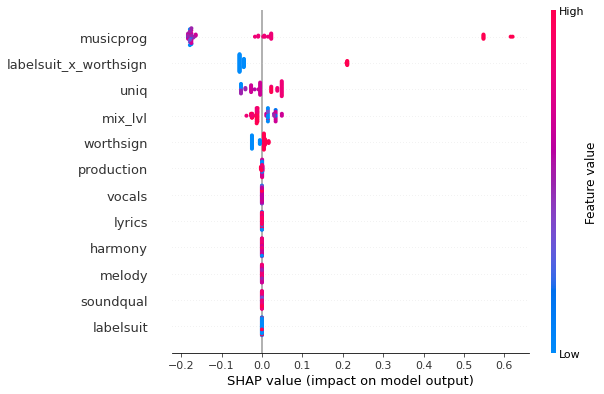

In [ ]:
#def train_model(data):
feature_cols = ['labelsuit_x_worthsign', 'production','worthsign', 'labelsuit', 'musicprog', 'mix_lvl', 'soundqual', 'melody', 'harmony', 'uniq', 'lyrics', 'vocals']
y = df1.signed
X = df1[feature_cols]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

param = {'num_leaves': 128, 'objective': 'binary', 
         'metric': 'auc', 'seed': 7}
print("Training model!")
bst1 = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

y_pred = bst1.predict(X_valid[feature_cols])
valid_score = sklearn.metrics.roc_auc_score(y_valid, y_pred)
print(f"Validation AUC score: {valid_score:.4f}")
#    return bst
#train_model(df1)


#precision, recall, fscore, train_support = score(y_valid, y_pred, pos_label=1, average='binary')
#print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {} / F1: {} / Support: {}'.format(
#    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_valid).sum()/len(y_pred), 3), round(fscore, 3), round(train_support)))


# Model Explanation

#eli5.lightgbm.explain_prediction_lightgbm(bst, X_valid)
explainer = shap.TreeExplainer(bst1,X_train)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid)

####7.2. LightGBM model - 'worthsign' as target

Training model!
Validation AUC score: 0.9625


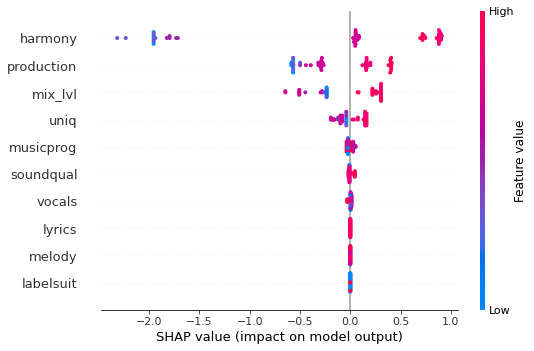

In [ ]:
feature_cols = ['labelsuit', 'musicprog', 'mix_lvl', 'soundqual', 'melody', 'harmony', 'uniq', 'production', 'vocals', 'lyrics']
y = df1.worthsign
X = df1[feature_cols]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

param = {'num_leaves': 128, 'objective': 'binary', 
         'metric': 'auc', 'seed': 7}
print("Training model!")
bst2 = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

valid_pred = bst2.predict(X_valid[feature_cols])
valid_score = sklearn.metrics.roc_auc_score(y_valid, valid_pred)
print(f"Validation AUC score: {valid_score:.4f}")

#precision, recall, fscore, train_support = score(y_valid, y_pred, pos_label=1, average='binary')
#print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {} / F1: {} / Support: {}'.format(
#    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_valid).sum()/len(y_pred), 3), round(fscore, 3), round(train_support)))


# Model Explanation

explainer = shap.TreeExplainer(bst2,X_train)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid)

#8. NLP Feature Engineering

####8.1. Modify the Dataset

In [ ]:
# Convert df2['id'] from str to int
df2['id'] = df2['id'].str.strip()
df2['id'] = pd.to_numeric(df2['id'], errors='coerce')

# Left join between df2 and df1 on id.
df3 = pd.merge(left=df2, right=df1, how='left' ,on='id')

# Pick only the rows which contains text
df3 = df3.loc[lambda df3: df3['text'] != '', :]
df3.head()



,id,record_label,audio,text,signed,worthsign,labelsuit,soundqual,musicprog,production,vocals,lyrics,melody,harmony,uniq,mix_lvl,electronic,rock,pop,alternative,rb,military,children,folkwldcnt,funksoul,nonmusic,reggae,blues,classical,hiphop,jazz,latin,stgscreen,labelsuit_x_worthsign
0,0,Beat Boutique,https://sendemo.s3.amazonaws.com/uploads/1a645...,"hey, good afternoon and thanks for reaching me...",1,1,0,1.0,1.2,1.0,0.0,-0.0,1.2,1.3,-0.7,0.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,Friday Lights,https://sendemo.s3.amazonaws.com/uploads/eefb6...,Hey Oris! I really think you are onto somethin...,0,1,0,0.5,0.6,0.4,-0.9,-0.7,0.6,0.6,0.6,0.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,Friday Lights,https://sendemo.s3.amazonaws.com/uploads/c042c...,"Hello, Dear Blusm Tusm! Thank you for sending ...",0,0,0,0.5,-0.0,-0.2,0.0,-0.0,-1.4,-1.4,0.6,0.9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,Friday Lights,https://sendemo.s3.amazonaws.com/uploads/09cff...,Hey and thank you so much for sending us your ...,0,0,0,0.5,-0.6,0.4,-0.1,-1.8,-0.7,-0.7,-0.7,0.9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,8,Friday Lights,https://sendemo.s3.amazonaws.com/uploads/8b029...,Hello Rona. Tnx for sending this track. I actu...,0,0,0,0.5,-1.2,-1.5,-2.6,-2.9,-2.7,-2.7,-2.6,-2.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


####8.2. SpaCy NLP Function Creation - Text Classification Model


In [ ]:
# Import English dictionary
nlp = spacy.blank("en")

# Create the TextCategorizer with exclusive classes and "bow" architecture
textcat = nlp.create_pipe("textcat",config={
                                            "exclusive_classes": True,
                                            "architecture": "bow"})

# Add the TextCategorizer to the empty model
nlp.add_pipe(textcat)

# Add labels to text classifier
textcat.add_label('signed')

# Training Function
def train(model, train_data, optimizer, batch_size=8):
    losses = {}
#    random.shuffle(train_data)
    batches = minibatch(train_data, size=batch_size)
    for batch in batches:
        texts, labels = zip(*batch)
        model.update(texts, labels, sgd=optimizer, losses=losses)
    return losses

# Fix seed for reproducibility
spacy.util.fix_random_seed(1)
random.seed(1)

optimizer = nlp.begin_training()
#train_data = df3[text]
#losses = train(nlp, train_data, optimizer)
#print(losses['textcat'])

# Prediction Function
def predict(model, texts): 
    docs = [model.tokenizer(text) for text in texts]
    textcat = model.get_pipe('textcat')
    scores, _ = textcat.predict(docs)    
    predicted_class = scores.argmax(axis=1)
    return predicted_class

# Evaluation Function
def evaluate(model, texts, labels):
    predicted_class = predict(model, texts)
    true_class = [int(each['cats']['POSITIVE']) for each in labels] # EDIT LABELS    
    correct_predictions = predicted_class == true_class    
    accuracy = correct_predictions.mean()
    return accuracy


print('Go on mate!')

Go on mate!


#### 8.3. Text Classification - NLTK functions



In [ ]:
# Stopwords
stopwords = nltk.corpus.stopwords.words('english')
# Stemmer
ps = nltk.PorterStemmer()
# Lemmatizer
wn = nltk.WordNetLemmatizer()
# N-Grams
ngram_vect = CountVectorizer(ngram_range=(2,2))

# Text Cleaner Function
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

# TF-IDF
tfidf_vect = TfidfVectorizer(analyzer=clean_text)

print("Setup succeed!")

Setup succeed!


####8.4. Embedded Text Model - Word2vec setup

In [ ]:
# Load word2vec module
nlp1 = spacy.load('en_core_web_sm')

# Data Prep
df3.fillna(value = df3.mean(), inplace=True)
# Disable pipelines
with nlp1.disable_pipes():
  doc_vectors = np.array([nlp1(text).vector for text in df3.text])

# Print vector shape    
doc_vectors.shape

# Similarity function
#def similarity(a, b):
#    return np.dot(a, b)/np.sqrt(a.dot(a)*b.dot(b))

(96, 96)

#9. Text Classification Model - NGram and TF-IDF

####9.1. 'signed' as a target

In [ ]:
# Prepare Data
nltk.download('wordnet')
tfidf_vect_fit = tfidf_vect.fit(df3['text'])
tfidf_train = tfidf_vect_fit.transform(df3['text'])
df_vect = pd.concat([df3['signed'].reset_index(drop=True), 
          pd.DataFrame(tfidf_train.toarray())], axis=1)
df_vect.fillna(value = df_vect.mean(), inplace=True)


# Features and Target selection
y = df_vect.signed.astype(int)
X = df_vect.drop(['signed'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)
X.describe()


# Fit Model
gb1 = sklearn.ensemble.GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb1.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_valid)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_valid, y_pred, pos_label=1, average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {} / F1: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_valid).sum()/len(y_pred), 3), round(fscore, 3)))

# Use predictions as indicator for ensembled models.
print(len(gb_model.predict(X)))
df3['text_pred'] = gb_model.predict(X)
df3.tail()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Fit time: 0.436 / Predict time: 0.002 ---- Precision: 1.0 / Recall: 1.0 / Accuracy: 1.0 / F1: 1.0
96


,id,record_label,audio,text,signed,worthsign,labelsuit,soundqual,musicprog,production,vocals,lyrics,melody,harmony,uniq,mix_lvl,electronic,rock,pop,alternative,rb,military,children,folkwldcnt,funksoul,nonmusic,reggae,blues,classical,hiphop,jazz,latin,stgscreen,labelsuit_x_worthsign,text_pred
182,182,ICONYC Music,https://sendemo.s3.amazonaws.com/uploads/fb8bf...,Hi Konstantin thanks for getting in touch and ...,1,1,1,1.0,1.2,1.0,0.0,-0.0,1.2,1.3,1.3,0.9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
184,184,Manual Music,https://sendemo.s3.amazonaws.com/uploads/25f26...,"Hi Alfonso, nice to hear from you and thanks f...",0,0,1,0.5,0.6,-0.2,0.0,-0.0,0.6,0.6,-0.0,-0.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
186,186,Manual Music,https://sendemo.s3.amazonaws.com/uploads/e9d93...,Thanks for sharing this one with me too. Perso...,0,0,1,-0.1,-0.0,0.4,0.0,-0.0,0.6,-0.1,-0.0,0.9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
188,188,ICONYC Music,https://sendemo.s3.amazonaws.com/uploads/47b50...,"Hi Jack, thanks for getting in touch and sendi...",1,1,1,0.5,1.2,1.0,0.0,-0.0,0.6,0.6,0.6,0.9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
190,190,Manual Music,https://sendemo.s3.amazonaws.com/uploads/0013f...,"Hi guys, thanks for sharing your music with me...",0,0,0,-0.1,-0.0,-0.2,0.0,-0.0,-0.1,-0.1,-0.0,-0.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


####9.2. 'worthsign' as a target

In [ ]:
# Prepare Data
nltk.download('wordnet')
tfidf_vect_fit = tfidf_vect.fit(df3['text'])
tfidf_train = tfidf_vect_fit.transform(df3['text'])
df_vect = pd.concat([df3['worthsign'].reset_index(drop=True), 
          pd.DataFrame(tfidf_train.toarray())], axis=1)
df_vect.fillna(value = df_vect.mean(), inplace=True)


# Features and Target selection
y = df_vect.worthsign.astype(int)
X = df_vect.drop(['worthsign'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)
X.describe()


# Fit Model
gb2 = sklearn.ensemble.GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb2.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_valid)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_valid, y_pred, pos_label=1, average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {} / F1: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_valid).sum()/len(y_pred), 3), round(fscore, 3)))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Fit time: 0.678 / Predict time: 0.003 ---- Precision: 0.688 / Recall: 0.733 / Accuracy: 0.625 / F1: 0.71


#10. NLP Embedded Model - Word2vec

####10.1. Embedded Model

In [ ]:
# Data Prep
y = df3.signed.astype(int)
X = doc_vectors
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size=0.1, random_state=1)

embedded_model1 = sklearn.svm.LinearSVC(random_state=1, dual=False)
embedded_model1.fit(X_train, y_train)
y_pred = embedded_model1.predict(X_valid)

#print(f'test accuracy: {embedded_model1.score(X_valid, y_valid):.3f}')

precision, recall, fscore, train_support = score(y_valid, y_pred, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / Accuracy: {} / F1: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_valid).sum()/len(y_pred), 3), round(fscore, 3)))

Precision: 0.667 / Recall: 0.667 / Accuracy: 0.8 / F1: 0.667


#11. Ensembled Model - NLP(TF-IDF) X DNN

####11.1. 'signed' as a target

In [ ]:
# Data Preperation
y = df3.signed
feature_cols = ['text_pred', 'labelsuit_x_worthsign', 'worthsign', 'labelsuit', 'musicprog', 'mix_lvl', 'soundqual', 'melody', 'harmony', 'uniq', 'production']
X = df3[feature_cols]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

# Model Creation
Emodel1 = tf.keras.models.Sequential()
Emodel1.add(tf.keras.layers.Dense(20, input_dim=len(feature_cols), activation='relu', name='input_layer'))
Emodel1.add(tf.keras.layers.Dense(15, activation='sigmoid', name='hid_layer_1'))
#model1.add(tf.keras.layers.Dense(6, activation='relu', name='hid_layer_2'))
Emodel1.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer'))
Emodel1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

# Create Logger
#tensorboard = TensorBoard(log_dir='logs/{}'.format(time.time()),
#                    histogram_freq = 1,
#                    embeddings_freq = 1,
#                    embeddings_data = X)
# Model Summary
Emodel1.summary()

# Model Fit
Emodel1.fit(train_X, train_y, batch_size=128, epochs=550, validation_split = 0.15, shuffle=True, verbose=2)#, callbacks=[tensorboard])

# Evaluate Model
print('\n# Evaluate on test data')
Eresults1 = Emodel1.evaluate(test_X, test_y, batch_size=128)
print('test loss, test acc:, test AUC:', Eresults1)

# Save Model
# Emodel1.save("sendemo_koryto_model.h5")
# print("Model saved to disk.")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 20)                240       
_________________________________________________________________
hid_layer_1 (Dense)          (None, 15)                315       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 16        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/550
1/1 - 0s - loss: 1.2649 - accuracy: 0.2295 - auc: 0.2204 - val_loss: 1.4232 - val_accuracy: 0.0909 - val_auc: 0.7500
Epoch 2/550
1/1 - 0s - loss: 1.2546 - accuracy: 0.2295 - auc: 0.2044 - val_loss: 1.4119 - val_accuracy: 0.0909 - val_auc: 0.8000
Epoch 3/550
1/1 - 0s - loss: 1.2443 - accuracy: 0.2295 - auc: 0.1801 - val_loss: 1.4006 - val_accuracy: 0.0909 - val_auc: 0.7500

####11.2. 'worthsign' as a target

In [ ]:
# Data Preperation
y = df3.worthsign
feature_cols = ['text_pred', 'labelsuit', 'musicprog', 'mix_lvl', 'soundqual', 'melody', 'harmony', 'uniq', 'production']
X = df3[feature_cols]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

# Model Creation
Emodel2 = tf.keras.models.Sequential()
Emodel2.add(tf.keras.layers.Dense(20, input_dim=len(feature_cols), activation='relu', name='input_layer'))
Emodel2.add(tf.keras.layers.Dense(15, activation='sigmoid', name='hid_layer_1'))
#model2.add(tf.keras.layers.Dense(6, activation='relu', name='hid_layer_2'))
Emodel2.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer'))
Emodel2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

# Create Logger
#tensorboard = TensorBoard(log_dir='logs/{}'.format(time.time()),
#                    histogram_freq = 1,
#                    embeddings_freq = 1,
#                    embeddings_data = X)
# Model Summary
Emodel2.summary()

# Model Fit
Emodel2.fit(train_X, train_y, batch_size=128, epochs=400, validation_split = 0.15, shuffle=True, verbose=2)#, callbacks=[tensorboard])

# Evaluate Model
print('\n# Evaluate on test data')
Eresults2 = Emodel2.evaluate(test_X, test_y, batch_size=128)
print('test loss, test acc:, test AUC:', Eresults2)

# Save Model
# Emodel2.save("sendemo_koryto_model.h5")
# print("Model saved to disk.")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 20)                200       
_________________________________________________________________
hid_layer_1 (Dense)          (None, 15)                315       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 16        
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
1/1 - 0s - loss: 0.6658 - accuracy: 0.6557 - auc: 0.5219 - val_loss: 0.6714 - val_accuracy: 0.6364 - val_auc: 0.6667
Epoch 2/400
1/1 - 0s - loss: 0.6595 - accuracy: 0.7049 - auc: 0.5677 - val_loss: 0.6690 - val_accuracy: 0.6364 - val_auc: 0.7833
Epoch 3/400
1/1 - 0s - loss: 0.6533 - accuracy: 0.7049 - auc: 0.6447 - val_loss: 0.6667 - val_accuracy: 0.6364 - val_auc: 0.783

#12. Ensembled Model - NLP(TF-IDF) X Gradient Boost

####12.1. 'sign' as a target

Training model!
Validation AUC score: 0.8750


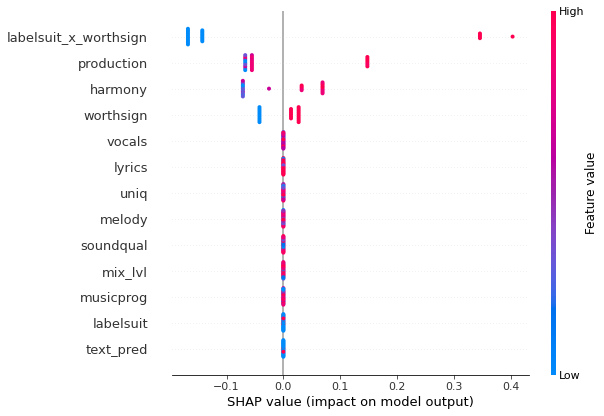

In [ ]:
feature_cols = ['text_pred','labelsuit_x_worthsign', 'production','worthsign', 'labelsuit', 'musicprog', 'mix_lvl', 'soundqual', 'melody', 'harmony', 'uniq', 'lyrics', 'vocals']
y = df3.signed
X = df3[feature_cols]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

param = {'num_leaves': 128, 'objective': 'binary', 
         'metric': 'auc', 'seed': 7}
print("Training model!")
Emodel3 = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

y_pred = Emodel3.predict(X_valid[feature_cols])
valid_score = sklearn.metrics.roc_auc_score(y_valid, y_pred)
#valid_acc = sklearn.metrics.accuracy_score(y_valid, y_pred)
print(f"Validation AUC score: {valid_score:.4f}")
#print(f"Validation accuracy score: {valid_acc:.4f}")


#precision, recall, fscore, train_support = score(y_valid, y_pred, pos_label=1, average='binary')
#print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {} / F1: {} / Support: {}'.format(
#    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_valid).sum()/len(y_pred), 3), round(fscore, 3), round(train_support)))


# Model Explanation

#eli5.lightgbm.explain_prediction_lightgbm(Emodel3, X_valid)
explainer1 = shap.TreeExplainer(Emodel3,X_train)
shap_values1 = explainer1.shap_values(X_valid, check_additivity=False)
shap.summary_plot(shap_values1, X_valid)

####12.2. 'worthsign' as a target

Training model!
Validation AUC score: 0.9222


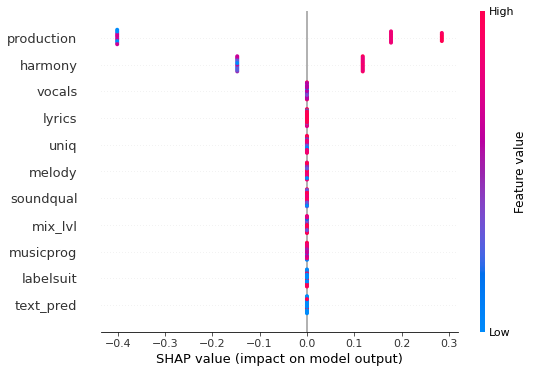

In [ ]:
feature_cols = ['text_pred', 'production', 'labelsuit', 'musicprog', 'mix_lvl', 'soundqual', 'melody', 'harmony', 'uniq', 'lyrics', 'vocals']
y = df3.worthsign
X = df3[feature_cols]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

param = {'num_leaves': 128, 'objective': 'binary', 
         'metric': 'auc', 'seed': 7}
print("Training model!")
Emodel4 = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

y_pred = Emodel4.predict(X_valid[feature_cols])
valid_score = sklearn.metrics.roc_auc_score(y_valid, y_pred)
#valid_acc = sklearn.metrics.accuracy_score(y_valid, y_pred)
print(f"Validation AUC score: {valid_score:.4f}")
#print(f"Validation accuracy score: {valid_acc:.4f}")


#precision, recall, fscore, train_support = score(y_valid, y_pred, pos_label=1, average='binary')
#print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {} / F1: {} / Support: {}'.format(
#    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_valid).sum()/len(y_pred), 3), round(fscore, 3), round(train_support)))


# Model Explanation

#eli5.lightgbm.explain_prediction_lightgbm(Emodel3, X_valid)
explainer2 = shap.TreeExplainer(Emodel4,X_train)
shap_values2 = explainer2.shap_values(X_valid, check_additivity=False)
shap.summary_plot(shap_values2, X_valid)

#15. Final Model Selection

##The selected model is (Emodel1,2) - NLP (TF-IDF) on Deep Neural Network.
The reason I selected this model stands mainly for the fact it outperformed every other model.

While the Gradient Boost models performed in a similar way to the Deep Neural Networks when it dealt with numerical values exclusively, the addition of the NLP model results as binary feature improved the DNN's performace significantly (100% accuracy). 

Unlike the DNN, the Gradient Boost model ignored the 'text_pred' feature.
Therefore, its performance decreased due to the decreasion in data volume.

As a conclusion, We can definitley know that the TF-IDF NLP model is being a critical factor for the model's success, yet it lacks the ability to make prediction for sparse feedbacks. The numerical values are essential if Sendemo's goal is to make a robust ML model that will be used in production.

For any further questions about this file, contact My:
+972-xx-xxxxxx